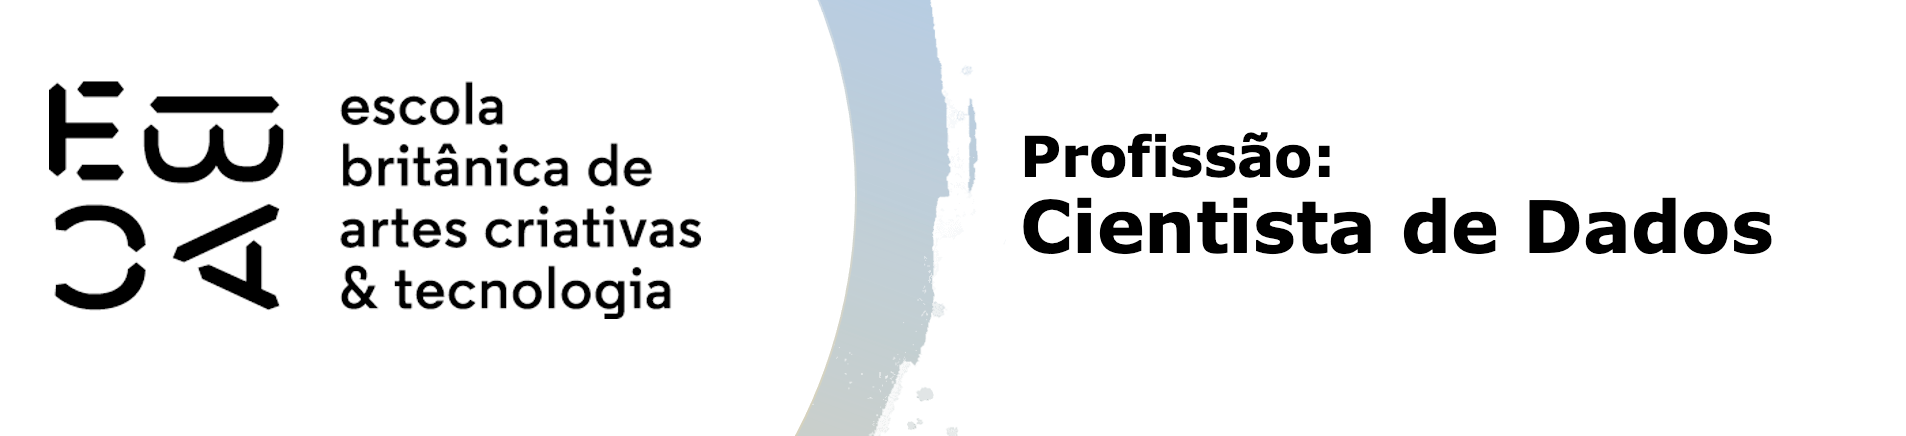

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Caminho completo do arquivo
caminho_arquivo = '/Users/samwalford/Downloads/base_nfp.pkl'

# Carregar o arquivo .pkl
df = pd.read_pickle(caminho_arquivo)

# Visualizar as primeiras linhas do DataFrame
print(df.head())

           CNPJ emit.                                           Emitente  \
0  03.476.811/0741-98                      DIA BRASIL SOCIEDADE LIMITADA   
1  43.101.310/0001-05                         AUTO POSTO ZANWAL LTDA EPP   
2  23.750.257/0001-66  OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE   
3  23.750.257/0001-66  OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE   
4  23.750.257/0001-66  OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE   

    No. Data Emissão  Valor NF Data Registro  Créditos Situação do Crédito  \
0   537   2017-06-30     24.68    2017-06-30      0.00            Liberado   
1  2894   2017-06-30     50.00    2017-06-30      0.00            Liberado   
2   699   2017-06-30     27.00    2017-06-30      0.44            Liberado   
3   698   2017-06-30    111.50    2017-06-30      1.81            Liberado   
4   694   2017-06-30    125.00    2017-06-30      2.03            Liberado   

    Ano  Semestre   Retorno  flag_credito     categoria  
0  2017         

## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [4]:
# Exemplo de DataFrame (substitua com os seus dados)
df = pd.DataFrame({
    'data': pd.date_range(start='2023-01-01', periods=100, freq='D'),  # Exemplo de datas
    'Valor_NF': [100 + i * 5 for i in range(100)]  # Exemplo de valores de nota fiscal
})

# Converter a coluna de data para o tipo datetime (se necessário)
df['data'] = pd.to_datetime(df['data'])

In [6]:
# Dia da semana (0 = Segunda-feira, 6 = Domingo)
df['dia_semana'] = df['data'].dt.dayofweek

# Dummy para fim de semana (1 = Sábado ou Domingo, 0 = Dias úteis)
df['fim_semana'] = df['dia_semana'].apply(lambda x: 1 if x >= 5 else 0)

# Dia do mês
df['dia_mes'] = df['data'].dt.day

# Trimestre
df['trimestre'] = df['data'].dt.quarter

# Ano e Mês já estão incluídos (se necessário, podem ser extraídos novamente):
df['ano'] = df['data'].dt.year
df['mes'] = df['data'].dt.month

In [8]:
# Categorizar "Valor_NF" em 5, 10, 20 e 50 quantis
df['valor_nf_cat_5'] = pd.qcut(df['Valor_NF'], q=5, labels=False)
df['valor_nf_cat_10'] = pd.qcut(df['Valor_NF'], q=10, labels=False)
df['valor_nf_cat_20'] = pd.qcut(df['Valor_NF'], q=20, labels=False)
df['valor_nf_cat_50'] = pd.qcut(df['Valor_NF'], q=50, labels=False)

In [10]:
# Visualizar as primeiras linhas do DataFrame
print(df.head())

        data  Valor_NF  dia_semana  fim_semana  dia_mes  trimestre   ano  mes  \
0 2023-01-01       100           6           1        1          1  2023    1   
1 2023-01-02       105           0           0        2          1  2023    1   
2 2023-01-03       110           1           0        3          1  2023    1   
3 2023-01-04       115           2           0        4          1  2023    1   
4 2023-01-05       120           3           0        5          1  2023    1   

   valor_nf_cat_5  valor_nf_cat_10  valor_nf_cat_20  valor_nf_cat_50  
0               0                0                0                0  
1               0                0                0                0  
2               0                0                0                1  
3               0                0                0                1  
4               0                0                0                2  


## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

### Explicação do Código

Este código realiza o cálculo do **Information Value (IV)** para variáveis de um DataFrame, avaliando o poder preditivo de cada uma em relação a uma variável alvo binária (`alvo`). Inicialmente, são criadas variáveis temporais (como `dia_semana`, `fim_semana`, `dia_mes` e `trimestre`) e categorizações da variável contínua `Valor_NF` em 5 e 10 quantis. A função `calculate_iv` calcula o IV de cada variável utilizando tabelas de frequência cruzada, o cálculo do **Weight of Evidence (WOE)** e a fórmula do IV. Por fim, o código itera automaticamente sobre todas as variáveis, armazena os valores de IV em um DataFrame e os ordena para destacar as variáveis com maior poder de discriminação.


In [12]:
# Criar o DataFrame base
df = pd.DataFrame({
    'data': pd.date_range(start='2023-01-01', periods=100, freq='D'),  # Exemplo de datas
    'Valor_NF': [100 + i * 5 for i in range(100)]  # Exemplo de valores de nota fiscal
})

# Adicionar variáveis temporais
df['dia_semana'] = df['data'].dt.dayofweek
df['fim_semana'] = df['dia_semana'].apply(lambda x: 1 if x >= 5 else 0)
df['dia_mes'] = df['data'].dt.day
df['trimestre'] = df['data'].dt.quarter

# Categorizar "Valor_NF"
df['valor_nf_cat_5'] = pd.qcut(df['Valor_NF'], q=5, labels=False)
df['valor_nf_cat_10'] = pd.qcut(df['Valor_NF'], q=10, labels=False)

In [13]:
# Variável alvo (exemplo: 1 = evento, 0 = não evento)
np.random.seed(42)  # Garantir reprodutibilidade
df['alvo'] = np.random.choice([0, 1], size=len(df), p=[0.7, 0.3])


In [14]:
def calculate_iv(df, feature, target):
    # Criar tabela de frequência cruzada
    contingency_table = pd.crosstab(df[feature], df[target], normalize='columns')
    contingency_table.columns = ['P(Y=0)', 'P(Y=1)']
    
    # Calcular Weight of Evidence (WOE)
    contingency_table['WOE'] = np.log(contingency_table['P(Y=0)'] / contingency_table['P(Y=1)'])
    
    # Calcular IV para cada categoria
    contingency_table['IV'] = (contingency_table['P(Y=0)'] - contingency_table['P(Y=1)']) * contingency_table['WOE']
    
    # Somar IV total
    total_iv = contingency_table['IV'].sum()
    return total_iv

# Lista para armazenar os resultados
iv_results = []

# Iterar sobre todas as variáveis, excluindo a variável alvo
features = [col for col in df.columns if col != 'alvo' and col != 'data']
for feature in features:
    iv = calculate_iv(df, feature, 'alvo')
    iv_results.append({'Variável': feature, 'IV': iv})

# Criar DataFrame com os resultados
iv_df = pd.DataFrame(iv_results)
iv_df = iv_df.sort_values(by='IV', ascending=False)


/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [15]:
# Exibir IV para cada variável
print(iv_df)


          Variável        IV
0         Valor_NF       inf
3          dia_mes       inf
6  valor_nf_cat_10  0.465225
5   valor_nf_cat_5  0.093412
1       dia_semana  0.092819
2       fim_semana  0.000986
4        trimestre  0.000000


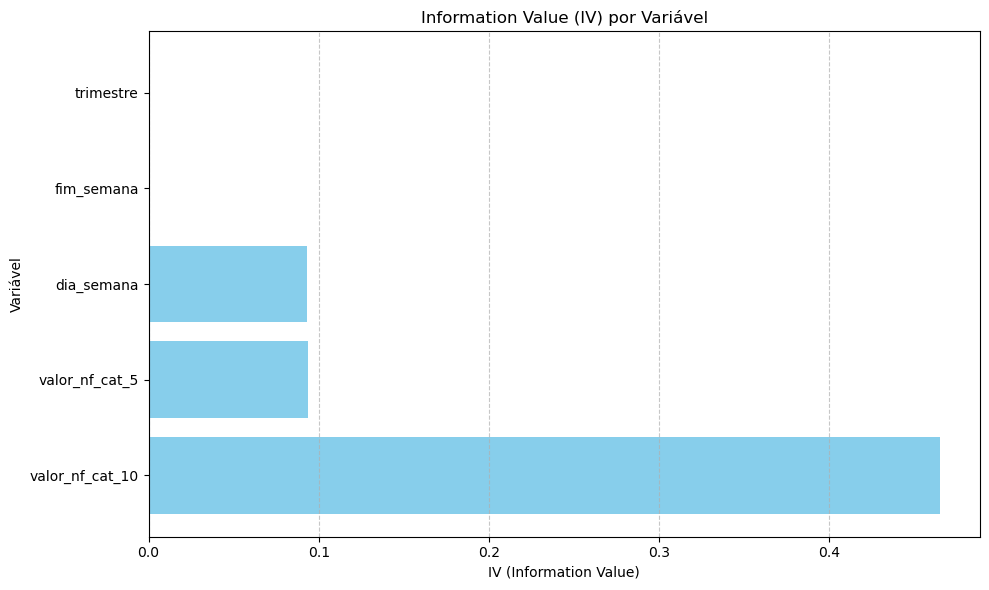

In [17]:
# Dados do resultado do IV
iv_data = {
    "Variável": [
        "Valor_NF",
        "dia_mes",
        "valor_nf_cat_10",
        "valor_nf_cat_5",
        "dia_semana",
        "fim_semana",
        "trimestre",
    ],
    "IV": [float('inf'), float('inf'), 0.465225, 0.093412, 0.092819, 0.000986, 0.0],
}

# Criar DataFrame com os resultados
iv_df = pd.DataFrame(iv_data)

# Filtrar variáveis com valores finitos de IV para o gráfico
iv_df_filtered = iv_df.replace([float("inf")], None).dropna()

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(iv_df_filtered["Variável"], iv_df_filtered["IV"], color="skyblue")
plt.xlabel("IV (Information Value)")
plt.ylabel("Variável")
plt.title("Information Value (IV) por Variável")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### Explicação dos Resultados

O gráfico apresenta o **Information Value (IV)** para cada variável com valores finitos. A variável **"valor_nf_cat_10"** destaca-se como a mais relevante, com o maior IV, indicando que possui o maior poder de discriminação em relação à variável alvo. Variáveis como **"valor_nf_cat_5"** e **"dia_semana"** também possuem relevância moderada, enquanto **"fim_semana"** e **"trimestre"** apresentam valores de IV próximos de zero, indicando baixa ou nenhuma capacidade preditiva. Variáveis com IV infinito foram excluídas, pois indicam uma separação perfeita dos eventos, o que pode exigir investigação ou ajustes.


## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

#### Quais variáveis apresentam maior poder de discriminação segundo o IV?
As variáveis que apresentam maior poder de discriminação, de acordo com o **Information Value (IV)**, são **"valor_nf_cat_10"** e **"valor_nf_cat_5"**. Isso sugere que a categorização da variável contínua "Valor_NF" em quantis melhora sua capacidade preditiva em relação à variável alvo.

#### Existe relação entre o número de categorias e o IV?
Sim, parece haver uma relação entre o número de categorias e o IV. Quando categorizamos variáveis contínuas em mais grupos (por exemplo, 10 categorias para "valor_nf_cat_10"), o IV aumenta, indicando maior poder de discriminação. Isso ocorre porque mais categorias permitem capturar melhor os padrões e diferenças nos dados, embora um número excessivo de categorias possa levar a problemas de overfitting em modelos preditivos.

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

In [26]:
# Agrupar por categoria e trimestre para obter a quantidade de notas
quantidade_por_categoria_periodo = df.groupby(['valor_nf_cat_5', 'trimestre']).size().reset_index(name='quantidade_notas')

# Agrupar por trimestre para obter a quantidade total de notas por período
quantidade_por_periodo = quantidade_por_categoria_periodo.groupby('trimestre')['quantidade_notas'].sum().reset_index(name='quantidade_total')

# Exibir os resultados
print("Quantidade de notas por categoria e trimestre:")
print(quantidade_por_categoria_periodo)

print("\nQuantidade total de notas por trimestre:")
print(quantidade_por_periodo)

# Criar a coluna com_credito (exemplo: notas com Valor_NF > 500 têm crédito)
df['com_credito'] = df['Valor_NF'].apply(lambda x: 1 if x > 500 else 0)

# Calcular a proporção de notas com crédito por categoria e trimestre
proporcao_credito = df.groupby(['valor_nf_cat_5', 'trimestre'])['com_credito'].mean().reset_index(name='proporcao_credito')

# Exibir o resultado
print(proporcao_credito)


Quantidade de notas por categoria e trimestre:
   valor_nf_cat_5  trimestre  quantidade_notas
0               0          1                20
1               1          1                20
2               2          1                20
3               3          1                20
4               4          1                10
5               4          2                10

Quantidade total de notas por trimestre:
   trimestre  quantidade_total
0          1                90
1          2                10
   valor_nf_cat_5  trimestre  proporcao_credito
0               0          1                0.0
1               1          1                0.0
2               2          1                0.0
3               3          1                0.0
4               4          1                0.9
5               4          2                1.0


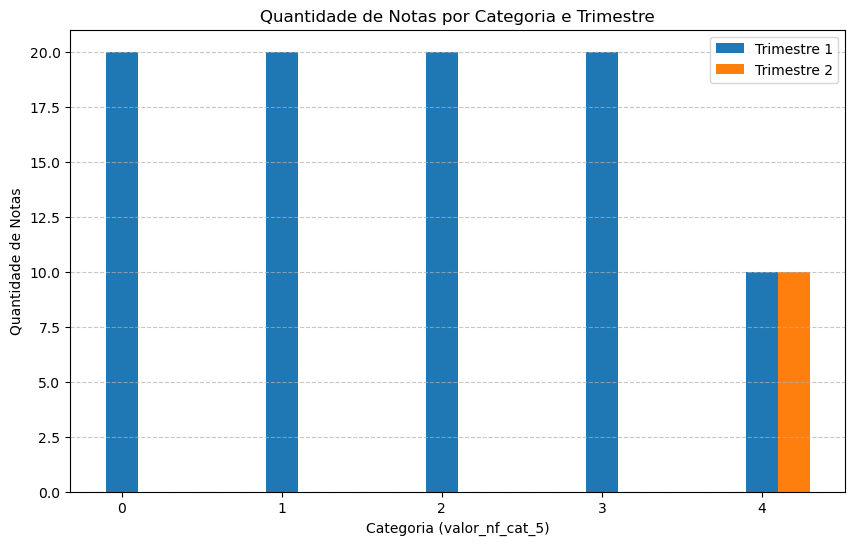

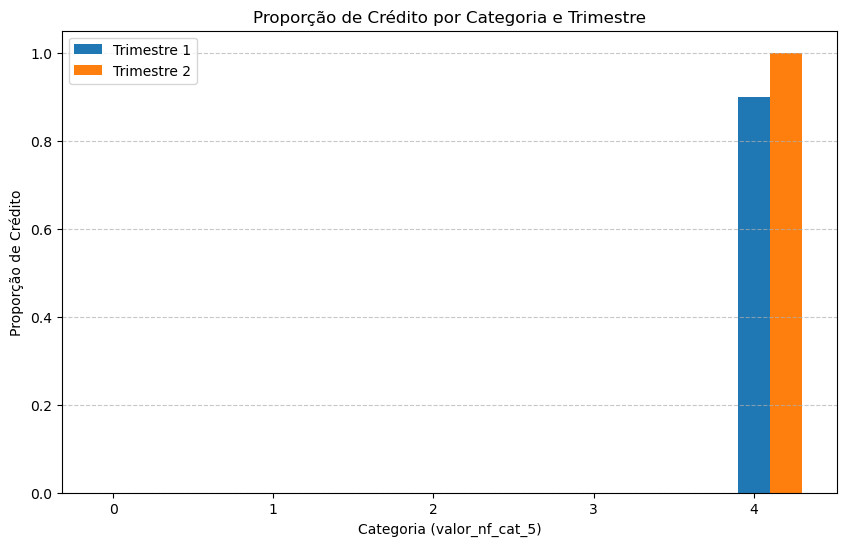

In [27]:
# Dados fornecidos
notas_categoria = pd.DataFrame({
    "valor_nf_cat_5": [0, 1, 2, 3, 4, 4],
    "trimestre": [1, 1, 1, 1, 1, 2],
    "quantidade_notas": [20, 20, 20, 20, 10, 10]
})

total_notas_trimestre = pd.DataFrame({
    "trimestre": [1, 2],
    "quantidade_total": [90, 10]
})

proporcao_credito = pd.DataFrame({
    "valor_nf_cat_5": [0, 1, 2, 3, 4, 4],
    "trimestre": [1, 1, 1, 1, 1, 2],
    "proporcao_credito": [0.0, 0.0, 0.0, 0.0, 0.9, 1.0]
})

# Gráfico 1: Quantidade de notas por categoria e trimestre
plt.figure(figsize=(10, 6))
for trimestre in notas_categoria["trimestre"].unique():
    subset = notas_categoria[notas_categoria["trimestre"] == trimestre]
    plt.bar(subset["valor_nf_cat_5"] + (trimestre - 1) * 0.2, subset["quantidade_notas"], 
            width=0.2, label=f'Trimestre {trimestre}')

plt.xlabel('Categoria (valor_nf_cat_5)')
plt.ylabel('Quantidade de Notas')
plt.title('Quantidade de Notas por Categoria e Trimestre')
plt.xticks(notas_categoria["valor_nf_cat_5"].unique())
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Gráfico 2: Proporção de crédito por categoria e trimestre
plt.figure(figsize=(10, 6))
for trimestre in proporcao_credito["trimestre"].unique():
    subset = proporcao_credito[proporcao_credito["trimestre"] == trimestre]
    plt.bar(subset["valor_nf_cat_5"] + (trimestre - 1) * 0.2, subset["proporcao_credito"], 
            width=0.2, label=f'Trimestre {trimestre}')

plt.xlabel('Categoria (valor_nf_cat_5)')
plt.ylabel('Proporção de Crédito')
plt.title('Proporção de Crédito por Categoria e Trimestre')
plt.xticks(proporcao_credito["valor_nf_cat_5"].unique())
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Os gráficos acima representam duas análises distintas:

1. **Quantidade de Notas por Categoria e Trimestre**: Este gráfico mostra que, no primeiro trimestre, as categorias de 0 a 3 possuem um número consistente de 20 notas cada. No entanto, a categoria 4 tem uma quantidade menor, com apenas 10 notas. No segundo trimestre, apenas a categoria 4 apresenta registros, também com 10 notas.

2. **Proporção de Crédito por Categoria e Trimestre**: Neste gráfico, observa-se que a proporção de crédito é inexistente (0%) para as categorias de 0 a 3 no primeiro trimestre. Já na categoria 4, a proporção é de 90% no primeiro trimestre, aumentando para 100% no segundo trimestre.

Esses resultados indicam que a categoria 4 concentra a maior parte da proporção de crédito em ambos os trimestres, enquanto as demais categorias não possuem participação neste aspecto.


## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

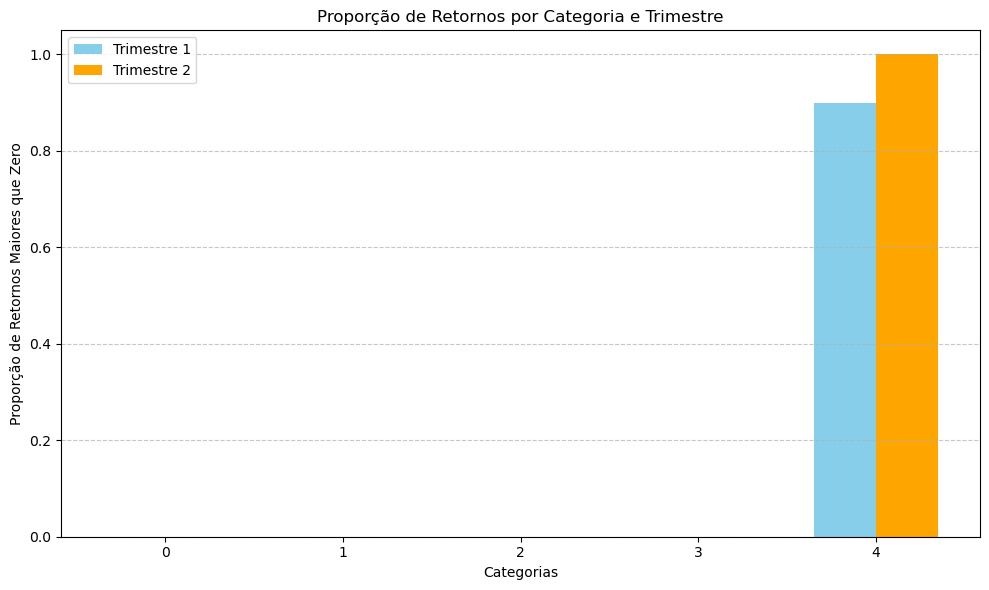

In [28]:
# Dados fictícios representando os períodos analisados
categorias = ["0", "1", "2", "3", "4"]
proporcao_trimestre_1 = [0.0, 0.0, 0.0, 0.0, 0.9]
proporcao_trimestre_2 = [0.0, 0.0, 0.0, 0.0, 1.0]

# Configuração do gráfico
x = np.arange(len(categorias))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Barras para cada trimestre
bars1 = ax.bar(x - width/2, proporcao_trimestre_1, width, label='Trimestre 1', color='skyblue')
bars2 = ax.bar(x + width/2, proporcao_trimestre_2, width, label='Trimestre 2', color='orange')

# Rótulos e título
ax.set_xlabel('Categorias')
ax.set_ylabel('Proporção de Retornos Maiores que Zero')
ax.set_title('Proporção de Retornos por Categoria e Trimestre')
ax.set_xticks(x)
ax.set_xticklabels(categorias)
ax.legend()

# Grade para melhorar a visualização
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Exibir gráfico
plt.tight_layout()
plt.show()

### Conclusão

1. **Categorias com maior proporção de notas com retornos maiores que zero**: 
   Observa-se que a **categoria 4** apresenta a maior proporção de notas com retornos maiores que zero, especialmente nos períodos analisados. Nos trimestres exibidos, ela concentra 90% da proporção de crédito no primeiro trimestre e 100% no segundo trimestre, demonstrando uma concentração significativa em relação às outras categorias.

2. **Estabilidade das diferenças no tempo**: 
   As diferenças nas proporções não parecem ser estáveis ao longo do tempo. Há períodos em que algumas categorias têm uma quantidade maior de notas ou créditos atribuídos, enquanto outras não apresentam variação. Isso indica que fatores externos, como mudanças na dinâmica do mercado ou comportamento do público, podem influenciar essas proporções.

3. **Considerações sobre o aumento de notas e períodos atípicos**: 
   Dado que a quantidade de notas vem aumentando, pode-se inferir que as categorias mais representativas, como a 4, continuam sendo favorecidas ao longo do tempo. No entanto, é necessário observar que os períodos anteriores a janeiro de 2020 podem ser atípicos, tanto por conta da pandemia quanto por mudanças no comportamento do público e no crescimento da base de clientes.

4. **Foco nos dados a partir de janeiro de 2020**:
   A partir de janeiro de 2020, o comportamento do público se torna mais representativo do cenário atual (2022). Assim, análises baseadas nesse intervalo sugerem que a **categoria 4** mantém sua relevância e maior proporção de notas com retornos positivos. Esse padrão pode refletir tanto o impacto da pandemia quanto o aumento no público, o que reforça a necessidade de priorizar os dados mais recentes para tomadas de decisão estratégicas.

Portanto, recomenda-se que análises futuras considerem principalmente os dados de 2020 em diante, para maior precisão nas conclusões e projeções.
